# MulticlassSN10 development

In [1]:
from pathlib import Path
import re
from typing import List
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import NegativeClassOptimization.config as config
import NegativeClassOptimization.utils as utils
import NegativeClassOptimization.datasets as datasets
import NegativeClassOptimization.preprocessing as preprocessing
import NegativeClassOptimization.ml as ml
from NegativeClassOptimization import visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
N = 100
NUM_CLASSES = 6

Define the dataset

In [3]:
# TODO: Add a label - Ag map! To log with mlflow later: class_encoding: "_".join(encoder.classes_)

dfs = ml.DataPipeline.load_processed_dataframes()
df = dfs["train_val"].sample(N).reset_index(drop=True)
print(f"{df.columns=}")

df = preprocessing.onehot_encode_df(df)

arr = preprocessing.arr_from_list_series(df["Slide_onehot"])
scaler = StandardScaler()
scaler.fit(arr)
arr = scaler.transform(arr)
# TODO: note scaling leaks to test set

antigens = df["Antigen"].unique().tolist()
encoder = LabelEncoder().fit(antigens)

df["X"] = arr.tolist()
df["y"] = encoder.transform(df["Antigen"])

df[["X", "y"]].head(3)

df.columns=Index(['Unnamed: 0.1', 'Unnamed: 0', 'ID_slide_Variant', 'CDR3', 'Best',
       'Slide', 'Energy', 'Structure', 'UID', 'Antigen',
       'Slide_farmhash_mod_10'],
      dtype='object')


,X,y
0,"[-0.294883912309794, 1.424887023698031, -0.175...",4
1,"[-0.294883912309794, -0.7018100265975378, -0.1...",4
2,"[-0.294883912309794, 1.424887023698031, -0.175...",0


In [4]:
def construct_dataset_loader(df: pd.DataFrame):
    dataset = datasets.MulticlassDataset(df)
    loader = DataLoader(
        dataset=dataset,
        batch_size=10,
        shuffle=False,
    )
    return dataset, loader    


df_train = df[["X", "y"]].sample(int(0.7*N))
df_test = df.loc[~df.index.isin(df_train.index)].copy()

train_dataset, train_loader = construct_dataset_loader(df_train.reset_index(drop=True))
test_dataset, test_loader = construct_dataset_loader(df_test.reset_index(drop=True))
open_dataset, open_loader = preprocessing.construct_open_dataset_loader(
    dfs["test_open_exclusive"].sample(int(N*4)).reset_index(drop=True),
    batch_size=10,
    scaler=scaler
)

Train loop

In [5]:
model = ml.MulticlassSN10(num_classes=NUM_CLASSES)
loss_fn = nn.CrossEntropyLoss()
optimizer = ml.construct_optimizer(
    optimizer_type="Adam",
    learning_rate=0.01,
    momentum=0.9,
    weight_decay=0,
    model=model,
)

online_metrics_per_epoch = []
for t in range(10):
    
    print(f"Epoch {t+1}\n-------------------------------")
    
    losses = ml.train_loop(train_loader, model, loss_fn, optimizer)
    test_metrics = ml.test_loop(test_loader, model, loss_fn)
    open_metrics = ml.openset_loop(open_loader, test_loader, model)
    
    online_metrics_per_epoch.append({
            "train_losses": losses,
            "test_metrics": test_metrics,
            "open_metrics": open_metrics,
        })

Epoch 1
-------------------------------
loss: 1.757373  [    0/   70]
Test Error: 
 Accuracy: 136.7%, Avg loss: 0.657574 

Epoch 2
-------------------------------
loss: 1.292306  [    0/   70]
Test Error: 
 Accuracy: 156.7%, Avg loss: 0.632186 

Epoch 3
-------------------------------
loss: 0.999709  [    0/   70]
Test Error: 
 Accuracy: 160.0%, Avg loss: 0.615271 

Epoch 4
-------------------------------
loss: 0.772518  [    0/   70]
Test Error: 
 Accuracy: 160.0%, Avg loss: 0.609815 



/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eugen/miniconda3/envs/nco/lib/python3

Epoch 5
-------------------------------
loss: 0.613037  [    0/   70]
Test Error: 
 Accuracy: 163.3%, Avg loss: 0.607606 

Epoch 6
-------------------------------
loss: 0.461088  [    0/   70]
Test Error: 
 Accuracy: 156.7%, Avg loss: 0.608539 

Epoch 7
-------------------------------
loss: 0.361745  [    0/   70]
Test Error: 
 Accuracy: 150.0%, Avg loss: 0.613310 

Epoch 8
-------------------------------
loss: 0.307113  [    0/   70]
Test Error: 
 Accuracy: 150.0%, Avg loss: 0.624043 



/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eugen/miniconda3/envs/nco/lib/python3

Epoch 9
-------------------------------
loss: 0.270491  [    0/   70]
Test Error: 
 Accuracy: 146.7%, Avg loss: 0.630912 

Epoch 10
-------------------------------
loss: 0.243996  [    0/   70]
Test Error: 
 Accuracy: 150.0%, Avg loss: 0.636983 



/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics:
- one vs rest (OVR) approach is preferred -- done
- F1 -- done
- ROC PR
    - average precision only for multilabel and binary, not multiclass problems.
- Kohen's kappa
    - Not relevant for us: The function cohen_kappa_score computes Cohen’s kappa statistic. This measure is intended to compare labelings by different human annotators, not a classifier versus a ground truth.
- MCC -- done
- confusion matrix -- done
- classification_report -- done

sklearn has the metrics that are required.

In [6]:
x_test, y_test = ml.Xy_from_loader(test_loader)
metrics_closed = model.compute_metrics_closed_testset(x_test, y_test)
metrics_closed

{'acc_closed': 0.23333333333333334,
 'acc_balanced_closed': 0.23095238095238094,
 'precision_weighted_closed': 0.30577200577200575,
 'precision_micro_closed': 0.23333333333333334,
 'precision_None_closed': array([0.5       , 0.        , 0.09090909, 0.        , 0.66666667,
        0.42857143]),
 'precision_macro_closed': 0.281024531024531,
 'recall_weighted_closed': 0.23333333333333334,
 'recall_micro_closed': 0.23333333333333334,
 'recall_None_closed': array([0.25      , 0.        , 0.25      , 0.        , 0.28571429,
        0.6       ]),
 'recall_macro_closed': 0.23095238095238094,
 'f1_weighted_closed': 0.2388888888888889,
 'f1_micro_closed': 0.23333333333333334,
 'f1_None_closed': array([0.33333333, 0.        , 0.13333333, 0.        , 0.4       ,
        0.5       ]),
 'f1_macro_closed': 0.22777777777777777,
 'roc_auc_weighted_closed': 0.628697696023783,
 'roc_auc_None_closed': array([0.78846154, 0.50694444, 0.47115385, 0.41346154, 0.72670807,
        0.808     ]),
 'roc_auc_macro_

Open set classification with MulticlassSN10


In [7]:
# open_metrics = ml.openset_loop(open_loader, test_loader, model)
x_open, _ = ml.Xy_from_loader(open_loader)
open_metrics = ml.compute_metrics_open_testset(model, x_open, x_test)
open_metrics

{'y_open_abs_logits': array([ 8.616001  ,  7.251564  ,  3.7807314 ,  5.6912785 ,  8.319261  ,
         6.6999407 ,  2.502732  ,  7.198225  ,  3.0253928 ,  4.5369325 ,
         5.179212  ,  3.752543  ,  2.355237  ,  5.031677  ,  0.6018308 ,
         7.5614996 ,  4.0955877 ,  5.388068  ,  4.2106266 ,  0.9520587 ,
         5.626961  ,  4.783251  ,  2.8848138 ,  1.8171939 ,  3.6981905 ,
         5.8320236 ,  3.4927838 ,  6.337402  ,  2.080934  ,  5.152018  ,
         4.2906466 ,  1.5904379 ,  8.109416  ,  3.8680365 ,  7.4552794 ,
         2.3128948 ,  8.261712  ,  5.402916  ,  2.6124866 ,  4.3402905 ,
         4.399291  ,  5.9668217 ,  5.2763124 ,  8.256877  ,  5.733508  ,
         3.327015  ,  0.6018308 ,  1.2401104 ,  5.051527  ,  9.13128   ,
         4.5761657 ,  3.5082161 ,  2.704999  ,  3.0025022 ,  0.6018308 ,
         8.482196  ,  3.6454082 ,  5.7246785 ,  2.5301557 ,  4.952973  ,
         2.4380946 ,  2.940964  ,  3.1830547 ,  6.5991645 ,  6.9774017 ,
         8.313063  ,  1.637906

Other artifacts: plots, text, dicts, etc.

- {precision_recall,roc}_curve work only in binary.

In [8]:
y_test_pred = model.predict(x_test)
print(metrics.classification_report(
    y_test, 
    y_test_pred,
    target_names=encoder.classes_
    ))

              precision    recall  f1-score   support

        1FBI       0.50      0.25      0.33         4
        1NSN       0.00      0.00      0.00         6
        1OB1       0.09      0.25      0.13         4
        1WEJ       0.00      0.00      0.00         4
        3VRL       0.67      0.29      0.40         7
        5E94       0.43      0.60      0.50         5

    accuracy                           0.23        30
   macro avg       0.28      0.23      0.23        30
weighted avg       0.31      0.23      0.24        30



(<Figure size 1000x700 with 1 Axes>,
 <AxesSubplot:title={'center':'Absolute logit distribution per open and closed set evaluation.\n'}, xlabel='abs_logits', ylabel='Probability'>)

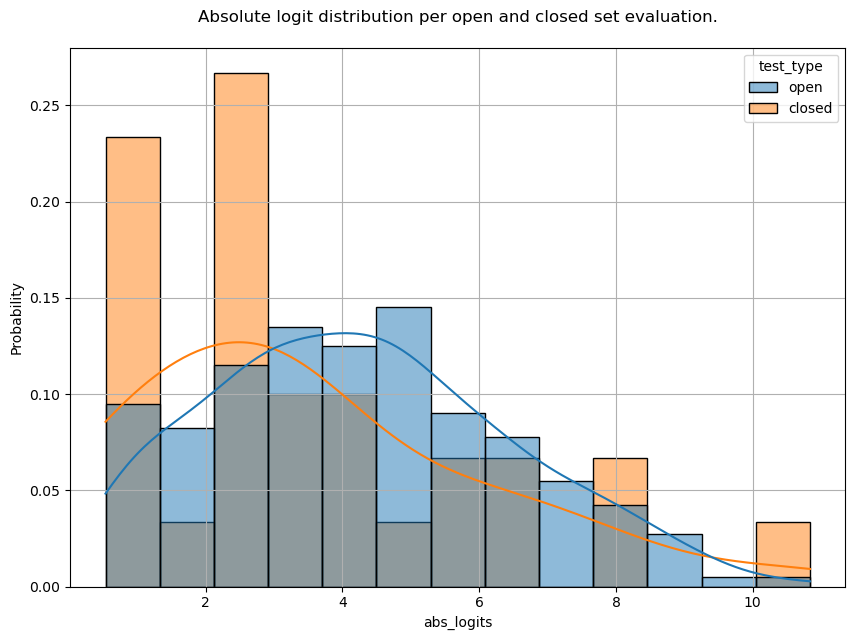

In [9]:
visualisations.plot_abs_logit_distr(
    open_metrics, 
    )

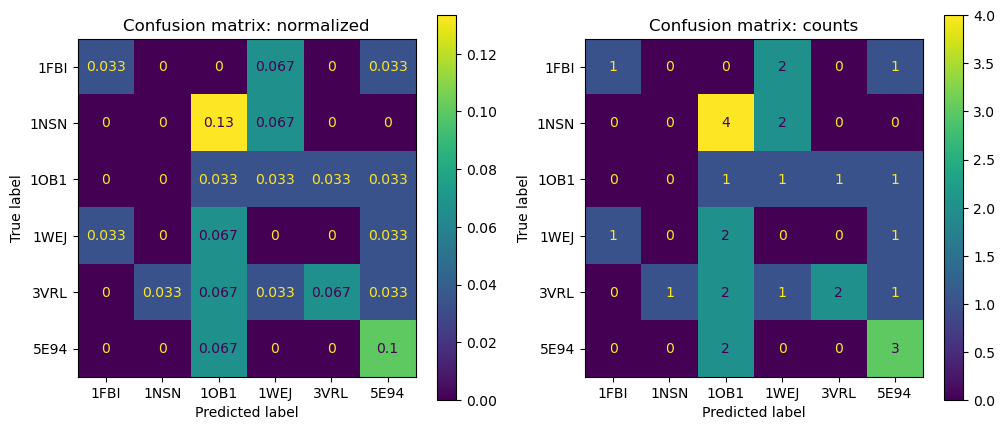

In [10]:
fig, axs = visualisations.plot_confusion(
    cm=test_metrics["confusion_matrix_closed"],
    cm_normed=test_metrics["confusion_matrix_normed_closed"],
    class_names=encoder.classes_,
)

In [17]:
# Building all k_class combinations

atoms = datasets.construct_dataset_atoms(config.ANTIGENS_CLOSEDSET)
atoms = list(filter(lambda atom: len(atom) > 2, atoms))
np.random.shuffle(atoms)

In [20]:
atoms

[('1FBI', '1NSN', '1OB1', '5E94'),
 ('1FBI', '1NSN', '5E94'),
 ('1NSN', '3VRL', '5E94'),
 ('1FBI', '1NSN', '1WEJ', '5E94'),
 ('1NSN', '1OB1', '1WEJ', '3VRL', '5E94'),
 ('1FBI', '1NSN', '1WEJ', '3VRL', '5E94'),
 ('1FBI', '1NSN', '1OB1', '3VRL', '5E94'),
 ('1WEJ', '3VRL', '5E94'),
 ('1FBI', '1NSN', '1OB1', '1WEJ', '3VRL', '5E94'),
 ('1FBI', '1OB1', '1WEJ', '3VRL'),
 ('1OB1', '3VRL', '5E94'),
 ('1FBI', '1WEJ', '3VRL', '5E94'),
 ('1NSN', '1OB1', '1WEJ'),
 ('1FBI', '1WEJ', '5E94'),
 ('1OB1', '1WEJ', '3VRL', '5E94'),
 ('1NSN', '1WEJ', '3VRL'),
 ('1NSN', '1OB1', '3VRL', '5E94'),
 ('1FBI', '1OB1', '1WEJ', '5E94'),
 ('1FBI', '3VRL', '5E94'),
 ('1FBI', '1OB1', '3VRL'),
 ('1NSN', '1WEJ', '5E94'),
 ('1NSN', '1OB1', '5E94'),
 ('1FBI', '1OB1', '1WEJ'),
 ('1OB1', '1WEJ', '5E94'),
 ('1FBI', '1NSN', '1WEJ', '3VRL'),
 ('1NSN', '1WEJ', '3VRL', '5E94'),
 ('1FBI', '1NSN', '3VRL'),
 ('1NSN', '1OB1', '1WEJ', '3VRL'),
 ('1NSN', '1OB1', '1WEJ', '5E94'),
 ('1FBI', '1NSN', '1WEJ'),
 ('1FBI', '1NSN', '1OB1', '3VR